In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")
for col in ["cityname", "state"]:
    data[col] = data[col].astype("category")
X = data.drop(columns=["price"])
y = data["price"]

# Random Forest
## 🌳 Hyperparameter des RandomForestRegressor

Die angegebenen Parameter definieren das Suchgitter (`rf_params`) für die **Optimierung der Hyperparameter** in der Nested Cross-Validation.

| Parameter | Beschreibung | Im Code definierte Werte |
| :--- | :--- | :--- |
| **`n_estimators`** | Gibt die **Anzahl der Bäume** (Entscheidungsbäume) im Random Forest an. | `[3]` |
| **`max_depth`** | Definiert die **maximale Tiefe** jedes Baums. Wichtig zur Kontrolle des **Overfittings**. | `[5, 10]` |
| **`min_samples_split`** | Gibt die **minimale Anzahl von Datenpunkten** an, die in einem Knoten vorhanden sein muss, damit dieser noch **geteilt** werden darf. | `[5, 10]` |
| **`min_samples_leaf`** | Gibt die **minimale Anzahl von Datenpunkten** an, die in einem Blatt vorhanden sein müssen. | `[5, 10]` |
| **`criterion`** | Nach welchem Kriterium wird gesplittet | `[gini, entropy]` |

In [8]:
from sklearn.ensemble import RandomForestRegressor
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding

rf_params = {
    "n_estimators": [3, 10, 20],
    "max_depth": [5, 10, None],
    "min_samples_split": [5, 10],
}

rf_cv = NestedCVRegressorWithTargetEncoding(RandomForestRegressor(random_state=42, ), rf_params, encode_cols=["state", "cityname"], scaler=None)
rf_cv.run(X, y)

print("Random Forest Mean R²:", rf_cv.get_mean_r2())
print("Random Forest best params:", rf_cv.get_best_params())

Random Forest Mean R²: 0.8156344836587343
Random Forest best params: [{'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 20}, {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 20}, {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 20}, {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 20}, {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 20}]


In [11]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['RandomForest'] * number_outer_cv_splits
model_evaluation['R_2'] = rf_cv.get_r2_scores()
model_evaluation['MSE'] = rf_cv.get_mse_scores()
model_evaluation["runtime"] = rf_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,RandomForest,0.822799,83794.112378,5.936669
1,2,RandomForest,0.810764,87762.026264,7.826486
2,3,RandomForest,0.811408,87790.918388,6.200627
3,4,RandomForest,0.809281,88510.480955,6.660907
4,5,RandomForest,0.823920,81769.920313,6.468600


In [12]:
model_evaluation.to_pickle('benchmarking/RandomForest.pkl')

--------------------------------------------------------------------------------------------------------------------------
## Feature Importance


In [19]:
#Modell vorbereiten mit besten Hyperparametern aus CV
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

rows_to_encode = ["cityname", "state"]

target_encoder = ce.TargetEncoder(
    cols=rows_to_encode,
    smoothing=10
)
best_params = rf_cv.get_best_params()[0]

rf_final_model = RandomForestRegressor(
    random_state=42,
    max_depth=best_params['model__max_depth'],
    min_samples_split=best_params['model__min_samples_split'],
    n_estimators=best_params['model__n_estimators']
)

model_pipeline = Pipeline([
    ("target_encoding", target_encoder),
    ("model", rf_final_model)
])


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('target_encoding', TargetEncoder(cols=['cityname', 'state'])),
                ('model',
                 RandomForestRegressor(min_samples_split=5, n_estimators=20,
                                       random_state=42))])

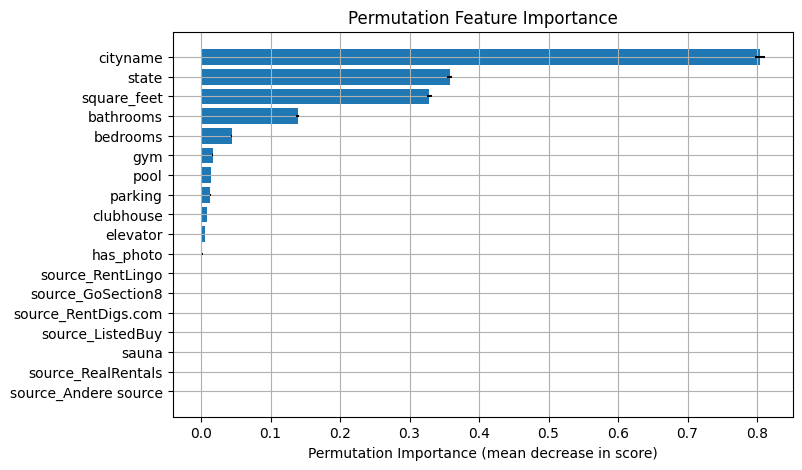

,feature,importance_mean,importance_std
12,source_Andere source,-0.000173,0.000033
15,source_RealRentals,-0.000064,0.000109
9,sauna,0.000000,0.000000
14,source_ListedBuy,0.000127,0.000048
16,source_RentDigs.com,0.000286,0.000189
13,source_GoSection8,0.000706,0.000049
17,source_RentLingo,0.001075,0.000298
2,has_photo,0.002036,0.000093
10,elevator,0.005953,0.000267
11,clubhouse,0.008614,0.000643


In [22]:
from permutation_importance_ import permutation_importance_analysis
permutation_importance_analysis(model_pipeline, X_val, y_val, show_plot=True, save_as_pkl=True, file_name="RandomForest")


# Decision tree

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   0.3s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   0.3s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   0.3s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   0.3s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=10; total time=   0.3s
[CV] END max_depth=3, min_samples_l

c:\Users\User\Git\DataProject-WS-25-26\Nested_CV.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


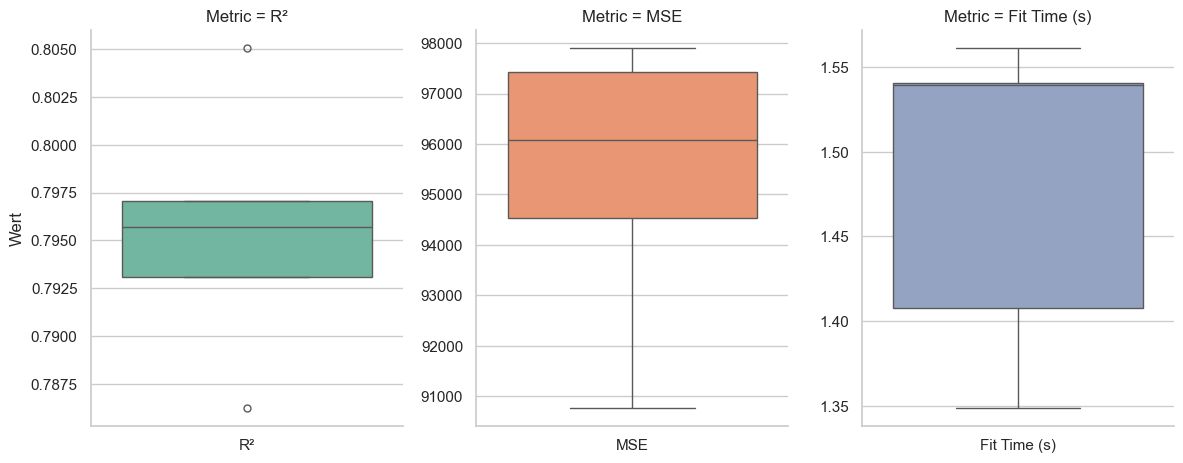

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_params = {
    "max_depth": [3, 5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
}

tree_cv = NestedCVRegressor(DecisionTreeRegressor(), tree_params)
tree_cv.run(X, y,output=True)



print("Tree Mean R²:", tree_cv.get_mean_r2())
print("Tree best params:", tree_cv.get_best_params())

tree_cv.plot_scores("Decision Tree Nested CV")

In [ ]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['Ridge'] * number_outer_cv_splits
model_evaluation['R_2'] = tree_cv.get_r2_scores()
model_evaluation['MSE'] = tree_cv.get_mse_scores()
model_evaluation["runtime"] = tree_cv.get_fit_times()
model_evaluation